# ML for ENG: Term Project Phase II

<br>

$\textbf{Authors:}$ Soo Min Kwon, Manish Kewalramani, Brian Cheng

<br>

# Image Dataset: Clustering

<br>
This part of the Jupyter Notebook is for the $\textbf{CIFAR-10 Dataset}$ for the task of $\textbf{clustering}$.

Each section of this notebook will have code accompanied by a $\textit{remark}$ section for reasoning of why and what is done in the codes.

In [193]:
# importing packages
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp

Below, we will be loading and reshaping the $\textbf{CIFAR-10}$ dataset into the format that we need for clustering.

<br>

## Pre-processing and Loading of Dataset

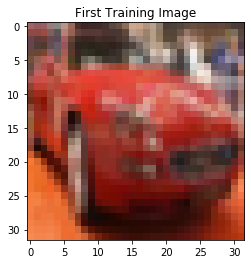

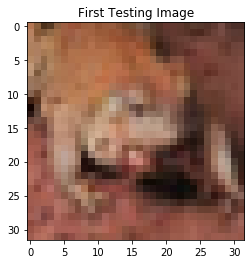

Label Names: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Shape of Training Data: (50000, 32, 32, 3)
Shape of Training Data Labels: (50000, 1)
Shape of Testing Data: (10000, 32, 32, 3)
Shape of Testing Data Labels: (10000, 1)



In [194]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

file_path = 'CIFAR-10 Data'

num_files = 5
num_samples = 10000
num_image_data = 3072
image_dim = 32

training_data = np.zeros((num_samples*5, num_image_data))
training_labels = np.zeros((num_samples*5, 1))
training_label_names = []
testing_data = np.zeros((num_samples, num_image_data))
testing_labels = np.zeros((num_samples, 1))

st = 0
en = num_samples

for num in range(num_files):
    # for label names
    labels_dictionary = unpickle(file_path + '/batches.meta')
    training_label_names = labels_dictionary[b'label_names']
    
    # for training data
    training_data_dictionary = unpickle(file_path + '/data_batch_' + str(num))
    train_data_dict = training_data_dictionary[b'data']
    train_labels_dict = training_data_dictionary[b'labels']
    
    train_labels_dict = np.reshape(train_labels_dict, (num_samples, 1))
    training_data[st:en, :] = train_data_dict
    training_labels[st:en, :] = train_labels_dict
    
    # for testing data
    testing_data_dictionary = unpickle(file_path + '/test_batch')
    test_data_dict = testing_data_dictionary[b'data']
    test_labels_dict = testing_data_dictionary[b'labels']
    
    test_labels_dict = np.reshape(test_labels_dict, (num_samples, 1))
    testing_data = test_data_dict
    testing_labels = test_labels_dict
    
    st += num_samples
    en += num_samples

# reshaping data into images
cifar_train_data = np.reshape(training_data, (num_samples*5, 3, image_dim, image_dim))
cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)

cifar_test_data = np.reshape(testing_data, (num_samples, 3, image_dim, image_dim))
cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)

# printing one training and one testing image and showing shapes of data
one_train_image = cifar_train_data[5, :, :, :]
one_test_image = cifar_test_data[5, :, :, :]

plt.imshow(one_train_image.astype('uint8'))
plt.title('First Training Image')
plt.show()

plt.imshow(one_test_image.astype('uint8'))
plt.title('First Testing Image')
plt.show()

# printing shapes
print('Label Names: ' + str(training_label_names))
print('Shape of Training Data: ' + str(cifar_train_data.shape))
print('Shape of Training Data Labels: ' + str(training_labels.shape))
print('Shape of Testing Data: ' + str(cifar_test_data.shape))
print('Shape of Testing Data Labels: ' + str(testing_labels.shape) + '\n')


$\textit{Remarks:}$

The CIFAR-10 dataset can be downloaded with the following link: http://www.cs.toronto.edu/~kriz/cifar.html

After downloading the file with the link provided, the file containing the data has 7 "pickle" files. Each pickle file contains a Python Dictionary of elements needed for a ML algorithm. Though clustering is an unsupervised learning method, we can still utilize the labels to observe how well our clustering was performed. For each of the files in the data file:

The pickle file labeled "batches.meta" has the names of labels for each image. There are 10 different classes of images, so the shape of the array of labels should be 10. The names of labels are printed above. For example, a label of 0 would indicate the class of 'airplane'.

The pickle files labeled "data_batch_0, ..., data_batch_4" are the files for the training data. We reshape the data into a 4th order tensor with the following axis:
(samples, image_dimensions, image_dimensions, RGB 3 channels).

The pickle file labeled "test_batch" is the file for testing data. We reshape the data into a 4th order tensor with the following axis:
(samples, image_dimensions, image_dimensions, RGB 3 channels).

$\textit{Note: }$Since these images are small (32x32), they are not clear when shown.

<br>

## Feature Learning / Feature Extraction for K-Means

Each of our group members will do a different feature extraction method for K-means clustering. The three feature extraction methods that we will be exploring is $\textbf{Principal Component Analysis (PCA)}$, $\textbf{Scale-Invariant Feature Tranform (SIFT)}$ (on grayscale images), and $\textbf{SIFT}$ (on RGB images) with $\textbf{PCA}$. We decided to do three different feature extraction methods because we realized that doing K-means with Euclidean distance for image clustering was giving unsatisfactory results, and simply changing the distance metrics would have NOT made performance any better. The following blocks of codes is split by author, and labeled by each feature extraction methods used.

<br>

## K-Means Clustering with PCA

<br>

$\textbf{Author: }$ Soo Min Kwon

<br>

For this feature learning section, we will perform Principal Component Analysis (PCA) to reduce the dimensions of our data. To first perform PCA, we must center our data. Upon centering our data, we verify that it's centered and use the Scikit-Learn package. But before doing PCA, we will make our images grayscale. This is because working with RGB images may get complicated, and must by reshaped perfectly for decent results.

In [195]:
# mean centering for PCA
cifar_gray_train_data = rgb2gray(cifar_train_data)
cifar_gray_train_data = np.reshape(cifar_gray_train_data, (num_samples*5, image_dim*image_dim))

mean_scaler = sklpp.StandardScaler(with_mean=True, with_std=False)
centered_train_data = mean_scaler.fit_transform(cifar_gray_train_data)

# verifying if mean was centered correctly
means = np.mean(centered_train_data, axis=0)

# verifying reshaped dimensions and centered mean
print('Reshaped Dimensions: ' + str(centered_train_data.shape))
print('Verification of Centered Mean: ' + str(means))

Reshaped Dimensions: (50000, 1024)
Verification of Centered Mean: [-6.7456053e-06 -1.3824463e-07 -4.5764159e-06 ...  1.8692016e-07
 -9.5970154e-06 -8.7265016e-06]


In the block of code above, we centered our data for PCA. We were able to verify that the mean was centered correctly using Scikit Learn by printing the means of the centered data.

<br>

In [196]:
# performing PCA with 95% energy capture
do_PCA = skldecomp.PCA(n_components=0.95, svd_solver='full')
cifar_features = do_PCA.fit_transform(centered_train_data)
num_pca_features = do_PCA.components_.shape[0]

print('Number of PCA Features with 95% Energy Capture: ' + str(num_pca_features))

Number of PCA Features with 95% Energy Capture: 160


$\textit{Remarks: }$

For the number of principal components to use for PCA, we ran our codes a couple times with different energy captures to see which would be best fit. Amongst our observations, we thought that it would be best suitable to use an energy capture of 95%, as it reduces dimensions significantly and can reconstruct the images upon projection quite well.

<br>

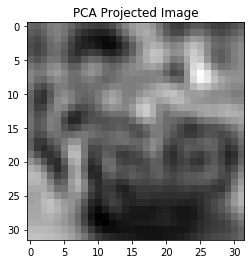

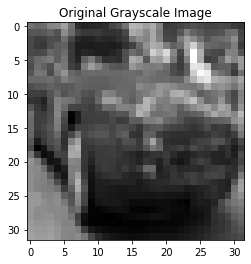

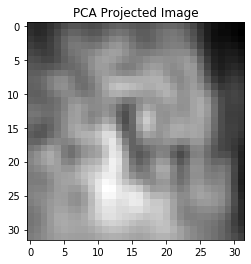

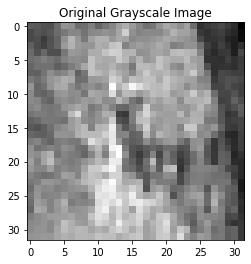

In [197]:
# projecting the features
cifar_projected_images = do_PCA.inverse_transform(cifar_features)
cifar_projected_images = np.reshape(cifar_projected_images, (num_samples*5, image_dim, image_dim))
plt.imshow(cifar_projected_images[5, :, :], cmap='gray')
plt.title('PCA Projected Image')
plt.show()

gray_image = np.reshape(cifar_gray_train_data, (50000, 32, 32))
plt.imshow(gray_image[5, :, :], cmap='gray')
plt.title('Original Grayscale Image')
plt.show()

plt.imshow(cifar_projected_images[10, :, :], cmap='gray')
plt.title('PCA Projected Image')
plt.show()

plt.imshow(gray_image[10, :, :], cmap='gray')
plt.title('Original Grayscale Image')
plt.show()

$\textit{Remarks:}$

The first two images are images of a car. The first image is the projected images after using PCA with an energy capture of 95%. The image following that is the original car image before any processing. The same goes for the next two images, which is a picture of a deer.

<br>

### Performing K-Means Clustering

In [198]:
# performing K-means clustering with 10 clusters
start_time_PCA = time.time()

kmeans = KMeans(n_clusters=10, random_state=0).fit(cifar_features)

end_time_PCA = time.time()

elapsed_time_PCA = end_time_PCA - start_time_PCA

print('Labels from K-Means Using PCA: ' + str(kmeans.labels_))
print('Computation Time for K-Means with PCA: ' + str(elapsed_time_PCA) + ' seconds')

Labels from K-Means Using PCA: [9 6 8 ... 8 1 4]
Computation Time for K-Means with PCA: 18.391259908676147 seconds


In [199]:
# printing shapes of data for verification
print('Dimensions of Data to be Clustered: ' + str(cifar_features.shape))
print('Dimensions of Labels from K-Means: ' + str(kmeans.labels_.shape))
print('Dimensions of True Labels: ' + str(training_labels.shape))

Dimensions of Data to be Clustered: (50000, 160)
Dimensions of Labels from K-Means: (50000,)
Dimensions of True Labels: (50000, 1)


$\textit{Remarks: }$

In the blocks of code above, we verified the dimensions of all of our variables to double check that everything came out correctly. The data that we used for clustering was the one we processed using PCA, with the columns being the number of principal components used.

The K-Means algorithm implemented on Scikit-Learn was the one we learned in class, which was the $\textit{Lloyd's algorithm for Quantization}$. The algorithm initializes 10 clusters randomly, computes the centroid of each cluster, keeps cluster with the smallest Euclidean distance value, and loops until no more changes occur.

As for the code, the "n_clusters" argument defines the number of clusters to be used. Since we have 10 different classes of images, we use 10 clusters. The "fit" followed by the input computes K-means clustering given the data to be clustered. The "random_state" determines random number generation for centroid initialization. It is often unnecessary for an input for this arugment. The distance metric that Scikit-Learn uses by default for K-means is the Euclidean distance.

For more information: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

<br>

In [200]:
# for visualization of true and predicted labels
print('True Labels:     ' + str((training_labels[0:35].T).astype(int)))
print('Predicted Labels: ' + str(np.asarray(kmeans.labels_[0:35])))

True Labels:     [[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4]]
Predicted Labels: [9 6 8 3 2 2 6 0 7 2 3 4 4 3 2 1 1 9 4 0 5 3 3 2 2 4 2 3 4 1 6 8 2 9 4]


$\textit{Remarks: }$

Just to visualize how well K-means clustering performed, we observe and compare the first 35 true and predicted labels. Obviously, the labels shouldn't exactly match. Scikit-Learn does not know how the true labels are indexed. However, if there are patterns in the true labels (e.g. 1, 1, 2, 2) then there should be the same patterns but with different (or same) numbers in the same indices (e.g. 3, 3, 4, 4). For example, in the print statement above, if we look at 5th and 6th indices for both true and predicted labels, we can observe this pattern. 

$\textbf{Note:}$ This is just for visualization.

In [201]:
# hand-made confusion matrix
confusionmatrix = np.zeros((10,10))

st = 0
en = 1

for k in range(50000):
    x = int(kmeans.labels_[st:en])
    y = int(training_labels[st:en])
    confusionmatrix[x][y] += 1
    st+=1
    en+=1
print('Confusion Matrix with PCA as Features: ' + '\n' + str(confusionmatrix))

Confusion Matrix with PCA as Features: 
[[ 240.  387.  410.  698. 1068.  709.  459.  891.  188.  188.]
 [ 695.  480.  200.  156.  201.  107.   79.  236. 1324.  670.]
 [ 400.  997.  750.  629.  782.  519.  922.  605.  378.  773.]
 [ 214.  457.  511.  626.  488.  457.  829.  265.  168.  148.]
 [ 433.  478.  427.  465.  353.  411.  472.  999.  207.  721.]
 [ 955.  257.  430.  299.  143.  182.  260.  169.  213.  199.]
 [ 699.  620.  996.  609.  855.  792.  815.  605.  938.  567.]
 [ 743.  117.  801.  548.  609.  704.  327.  455.  317.   95.]
 [ 392.  678.  182.  250.  195.  144.  125.  422.  798. 1488.]
 [ 229.  529.  293.  720.  306.  975.  712.  353.  469.  151.]]


$\textit{Remarks: }$

Since the label numbers from K-means and the true labels don't directly match, we created a hand-made confusion matrix with the rows being the predicted classes and the columns being the true classes. The way that we created this confusion matrix is that we iterated through both arrays of labels and incremented the confusion matrix in that specific position given the number of labels.

$\textbf{Example:}$

Let's say that the predicted class for the first index for K-means labels was 2, and for that same index, the true label was 7. Then, the [7][2] index of the confusion matrix would be incremented by 1. Ideally, we should see a very high number in one element of a column of the confusion matrix, and the rest low numbers in the elements of the same column. 

## K-Means Clustering with SIFT
<br>

$\textbf{Author: }$ Brian Cheng

<br>

K-Means clustering using the PCA features did not get the results we wanted, and upon reaching out for advice, we decided to take a new approach for our feature learning method, which was to use the vectors from SIFT as features. Scale-Invariant Feature Tranform (SIFT) has 4 steps in its algorithm:

1. Scale-Space Extrema Detection

We first detect keypoint extremas by running Gaussian and Laplacian filters over the images. This can be computationally intensive because to find larger keypoints in portions of the image, we need larger filter sizes. So instead of using LoG (Laplacian of Gaussian), we use Difference of Gaussian, which is an approximation of LoG.

2. Keypoint Localization

Once potential keypoints are found, they have to be refined for more accurate results. We use the Taylor series expansion of scale space to get more accurate location of the keypoints, and if the intensity at this extrema is less than a threshold value, it is rejected.

3. Orientation Assignment

An orientation is assigned to each keypoint to achieve invariance to image rotation.

4. Keypoint Descriptor

Once the keypoints are oriented, a neighborhood around the keypoints are made.

<br>


For more details about SIFT on OpenCV: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html

<br>

In [202]:
# implmenting SIFT
cifar_gray_train_data = np.reshape(cifar_gray_train_data, (num_samples*5, image_dim, image_dim))

total_images = num_samples*5
target_keypoints = 39
dim_vec = 128

cifar_sift_features = np.zeros((total_images, target_keypoints, dim_vec))

for num in range(total_images):
    per_image = cifar_gray_train_data[num, :, :]
    gray_image = cv2.normalize(per_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    sift = cv2.xfeatures2d.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    
    cifar_sift_features[num, :len(keypoints), :] = cifar_sift_features[num, :len(keypoints), :] + descriptors 
    

$\textit{Remarks: }$

To use SIFT, we used a package implemented on OpenCV. The number of target_keypoints is 39 because that was the maximum number of keypoints given from all the images. If the image had less than 39 keypoints, we zero-padded to match 39 keypoints. Each keypoint had a 128-dimensional vector, so the whole feature matrix for each image had dimensions (39 x 128). We then vectorize these dimensions to fit it into the K-means clustering algorithm using Scikit Learn.

For more information on SIFT: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html

In [203]:
cifar_sift_features = np.reshape(cifar_sift_features, (total_images, target_keypoints*dim_vec))
print('Dimensions of Vectorized Features: ' + str(cifar_sift_features.shape))

Dimensions of Vectorized Features: (50000, 4992)


In [204]:
# using K-means onto new features
start_time_sift = time.time()

kmeans = KMeans(n_clusters=10, random_state=0).fit(cifar_sift_features)

end_time_sift = time.time()

elapsed_time_sift = end_time_sift - start_time_sift

print('Labels from K-Means Using SIFT: ' + str(kmeans.labels_))
print('Computation Time for K-Means with SIFT: ' + str(elapsed_time_sift) + ' seconds')

Labels from K-Means Using SIFT: [4 1 2 ... 5 6 7]
Computation Time for K-Means with SIFT: 385.67128801345825 seconds


In [205]:
print('True Labels:     ' + str((training_labels[0:35].T).astype(int)))
print('Predicted Labels: ' + str(np.asarray(kmeans.labels_[0:35])))

True Labels:     [[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4]]
Predicted Labels: [4 1 2 8 8 7 1 2 4 9 2 0 5 8 0 7 2 4 2 0 2 9 6 0 4 0 9 8 7 2 3 5 9 1 9]


In [206]:
# hand-made confusion matrix
confusionmatrix = np.zeros((10,10))

st = 0
en = 1

for k in range(50000):
    x = int(kmeans.labels_[st:en])
    y = int(training_labels[st:en])
    confusionmatrix[x][y] += 1
    st+=1
    en+=1
    
print('Confusion Matrix with SIFT as Features: ' + '\n' + str(confusionmatrix))

Confusion Matrix with SIFT as Features: 
[[ 337.  539.  348.  470.  493.  424.  489.  763.  177.  789.]
 [ 124.  352.  172.  296.  312.  515.  343.  567.   82.  517.]
 [ 662.  612.  674.  516.  552.  366.  514.  532.  526.  713.]
 [1465.  235.  916.  308.  332.  194.  302.  147. 1395.  158.]
 [ 192.  504.  339.  591.  460.  721.  574.  449.  242.  315.]
 [ 218.  615.  317.  550.  586.  657.  544.  751.  165.  762.]
 [ 338.  417.  485.  549.  573.  575.  583.  371.  620.  274.]
 [1052.  570.  947.  605.  674.  454.  577.  434. 1114.  485.]
 [ 239.  515.  404.  663.  504.  698.  644.  386.  399.  274.]
 [ 373.  641.  398.  452.  514.  396.  430.  600.  280.  713.]]


$\textit{Remarks: }$

Performing SIFT and using the resulting features for K-means clustering did not work very well. The way that we evaluated the K-means clustering algorithm was the same method that we did for PCA, which was to make a confusion matrix for the predicted and true class labels. 


<br>

## K-Means Clustering with SIFT and PCA

<br>

$\textbf{Author: }$ Manish Kewalramani

<br>

Since both methods (PCA and SIFT) for feature learning did not work very well, our third thought was to compare the computational complexity of SIFT vs. SIFT & PCA. Since the number of features for SIFT was quite large, the K-means clustering algorithm took a long time to finish. If we can get similar results for doing SIFT & PCA and just SIFT, we can conclude that it is better to do SIFT & PCA together, as it significantly reduces computational complexity and outputs similar results. Generally, however, since SIFT did not give satisfactory results, we shouldn't expect good results for SIFT & PCA.

<br>

In [207]:
# implmenting SIFT
total_images = num_samples*5
target_keypoints = 39
dim_vec = 128

cifar_sift_features = np.zeros((total_images, target_keypoints, dim_vec))

for num in range(total_images):
    per_image = cifar_train_data[num, :, :]
    image = cv2.normalize(per_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    sift = cv2.xfeatures2d.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    cifar_sift_features[num, :len(keypoints), :] = cifar_sift_features[num, :len(keypoints), :] + descriptors 

In [208]:
print('Dimensions of SIFT Features: ' + str(cifar_sift_features.shape))

Dimensions of SIFT Features: (50000, 39, 128)


$\textit{Remarks: }$

SIFT was performed the same way (using OpenCV) as previously done.

<br>

In [209]:
# PCA on SIFT features
cifar_sift_features = np.reshape(cifar_sift_features, (total_images, target_keypoints*dim_vec))
mean_scaler = sklpp.StandardScaler(with_mean=True, with_std=False)
centered_sift = mean_scaler.fit_transform(cifar_sift_features)

# verifying if mean was centered correctly
means = np.mean(centered_sift, axis=0)

# verifying reshaped dimensions and centered mean
print('Reshaped Dimensions: ' + str(centered_sift.shape))
print('Verification of Centered Mean: ' + str(means))

Reshaped Dimensions: (50000, 4992)
Verification of Centered Mean: [-4.38627978e-14  2.83759505e-14  2.20421725e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [210]:
# performing PCA with 95% energy capture
do_PCA = skldecomp.PCA(n_components=0.95, svd_solver='full')
cifar_features = do_PCA.fit_transform(centered_sift)
num_pca_features = do_PCA.components_.shape[0]

print('Number of PCA Features with 95% Energy Capture: ' + str(num_pca_features))

Number of PCA Features with 95% Energy Capture: 1457


In [211]:
print('Dimensions before PCA:' + str(centered_sift.shape))
print('Dimensions after PCA: ' + str(cifar_features.shape))

Dimensions before PCA:(50000, 4992)
Dimensions after PCA: (50000, 1457)


$\textit{Remarks: }$

PCA was performed the same way (using Scikit-Learn) as previously done.

<br>

In [212]:
# performing K-means
start_time_sift_PCA = time.time()

kmeans = KMeans(n_clusters=10, random_state=0).fit(cifar_features)

end_time_sift_PCA = time.time()

elapsed_time_sift_PCA = end_time_sift_PCA - start_time_sift_PCA

print('Labels from K-Means Using SIFT & PCA: ' + str(kmeans.labels_))
print('Computation Time for K-Means with SIFT & PCA: ' + str(elapsed_time_sift_PCA) + ' seconds')

Labels from K-Means Using SIFT & PCA: [6 0 9 ... 0 2 8]
Computation Time for K-Means with SIFT & PCA: 114.14728689193726 seconds


$\textit{Remarks: }$

K-means was performed the same way (using Scikit-Learn) as previously done.

<br>

In [213]:
print('True Labels:     ' + str((training_labels[0:35].T).astype(int)))
print('Predicted Labels: ' + str(np.asarray(kmeans.labels_[0:35])))

True Labels:     [[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4]]
Predicted Labels: [6 0 9 2 2 4 0 4 0 3 6 0 0 6 9 8 5 6 9 2 9 4 1 6 6 5 5 2 8 9 1 7 9 7 5]


In [214]:
# hand-made confusion matrix
confusionmatrix = np.zeros((10,10))

st = 0
en = 1

for k in range(50000):
    x = int(kmeans.labels_[st:en])
    y = int(training_labels[st:en])
    confusionmatrix[x][y] += 1
    st+=1
    en+=1
    
print('Confusion Matrix with SIFT as Features: ' + '\n' + str(confusionmatrix))

Confusion Matrix with SIFT as Features: 
[[ 278.  662.  322.  563.  503.  627.  551.  837.  193.  828.]
 [1198.  140.  754.  211.  343.  124.  251.   89. 1092.   99.]
 [ 248.  456.  424.  583.  544.  604.  611.  378.  446.  246.]
 [ 213.  580.  380.  603.  515.  649.  566.  460.  305.  403.]
 [ 665.  615.  717.  599.  662.  456.  623.  498.  718.  526.]
 [ 394.  524.  331.  423.  403.  350.  410.  648.  242.  806.]
 [ 138.  510.  316.  544.  437.  689.  520.  429.  216.  331.]
 [ 152.  465.  222.  413.  356.  658.  392.  638.   96.  634.]
 [1117.  462. 1017.  576.  722.  475.  629.  389. 1273.  373.]
 [ 597.  586.  517.  485.  515.  368.  447.  634.  419.  754.]]


$\textit{Remarks: }$

Evaluation of K-means was performed the same way (using hand-made confusion matrix) as previously done.

Since we still get unsatisfactory results, but the computation time was much faster, we can conclude that it is better to do SIFT & PCA than just SIFT.

<br>

$\textbf{Final Remarks: }$

Performing PCA, SIFT, and SIFT & PCA were not satisfactory for image clustering. Some future works can circle around exploring different feature learning methods on different images. We tried to do SURF and ORB on our dataset, but the image resolution was too poor to perform these feature methods.

Computation Time for K-Means with PCA: 18.3913 seconds

Computation Time for K-Means with SIFT: 385.671 seconds

Computation Time for K-Means with SIFT & PCA: 114.147 seconds

<br>

Above are the computation times for the K-means clustering algorithm without overhead. 

For production, our recommendation would be to NOT do clustering with images. However, if we had to choose a feature learning method for clustering with images, we would say to do PCA, as it takes the least computation time and achieves similar (bad) results. 

<br>

<br>

# Audio Dataset: Classification

<br>
This part of the Jupyter Notebook is for the $\textbf{Google Audioset Dataset}$ for the task of $\textbf{classification}$.

The machine learning objective is binary classification of either human speech or other sound (not human speech).

Each section of this notebook will have code accompanied by a $\textit{remark}$ section for reasoning of why and what is done in the codes.

<br>

Below, we will be loading and reshaping the $\textbf{Google Audioset}$ dataset into the format that we need for classification.

<br>

## Pre-processing and Loading of Dataset

In [1]:
# importing packages
import h5py
import numpy as np
from sklearn.svm import SVC
import time
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
# importing data
hdf5_path = 'bal_train.h5'

def load_data(hdf5_path):
    with h5py.File(hdf5_path, 'r') as hf:
        x = hf.get('x')
        y = hf.get('y')
        video_id_list = hf.get('video_id_list')
        x = np.array(x)
        y = list(y)
        video_id_list = list(video_id_list)
        
    return x, y, video_id_list

def uint8_to_float32(x):
    return (np.float32(x) - 128.) / 128.
    
def bool_to_float32(y):
    return np.float32(y)

(x, y, video_id_list) = load_data(hdf5_path)
x = uint8_to_float32(x)
y = bool_to_float32(y) 

$\textit{Remarks: }$

The above cell was used to load the training data of feature vectors into workable numpy arrays. The dataset is audio samples from 10 second youtube clips with 128 dimensional feature vectors sampled at 1 Hz. The data was downloaded preprocessed from the Google Audioset Website. The preprocessing steps that they took were the following:

- Instead of raw audio, every example is made available as a sequence of 128-dimension embeddings (one embedding for every second of audio). The embeddings were obtained after passing the log-scaled mel-spectrograms of the audio waveform through a deep convolutional neural network trained on millions of audio clips (VGGish). 

Link for VGGish: https://resources.wolframcloud.com/NeuralNetRepository/resources/VGGish-Feature-Extractor-Trained-on-YouTube-Data

<br>

In [3]:
print('Dimensions of Data: ' + str(x.shape))
print('Dimensions of Labels: ' + str(y.shape))

Dimensions of Data: (22160, 10, 128)
Dimensions of Labels: (22160, 527)


$\textit{Remarks: }$

Since the each audio clip was 10 seconds long in total and our 128 dimensional feature vectors were extracted from samples taken at 1 Hz, the dimensions of our data is 22160 (total number of samples) $\times$ 10 (total number of seconds in an audio clip) $\times$ 1 Hz (sampling rate) $\times$ 128 (feature vector size). 

The labels were originally "one-hot" encoded, so the dimensions of each label are 527, for the number of different classes in the dataset.

In [4]:
# changing one-hot encoding
newlabels = np.zeros((22160))
counter = 0
for i in range(y.shape[0]):
    if y[i][0] == 1:
        newlabels[i] = 1
        counter += 1
    
# label of 1 indicates human speech, label of 0 indicates not human speech
print('Shape of New Labels for Each Audio Clip: ' + str(newlabels.shape))
print('Total of Human Speech in Dataset: ' + str(counter))
print('New Labels: ' + str(newlabels))

Shape of New Labels for Each Audio Clip: (22160,)
Total of Human Speech in Dataset: 5735
New Labels: [0. 1. 0. ... 1. 0. 0.]


$\textit{Remarks: }$

In the cell above, we changed all the "one-hot" encoded labels into labels of 0 or 1. A label of 1 means that the audio clip is human speech and a label of 0 means not human speech. We can verify that the labels were correctly translated, as the new labels are now either 0 or 1 in the print statement above.

From the whole dataset, there is a total of 5735 audio clips that are labeled as human speech. We were able to determine this number from a .csv file that had all the audio clips labeled.

Below, we reshape our data into vectors to fit into our classifiers.

In [5]:
# reshaping into vectors
sample_size = x.shape[0]
seconds = 10
samp_freq = 128
xvectors = np.reshape(x, (sample_size, seconds*samp_freq))
print('Dimensions of Reshaped Data: ' + str(xvectors.shape))

Dimensions of Reshaped Data: (22160, 1280)


In [41]:
# testing SVM with a different dataset
hdf5_path = 'eval.h5'

(xtest, ytest, video_id_list) = load_data(hdf5_path)
xtest = uint8_to_float32(xtest)
ytest = bool_to_float32(ytest)   

In [42]:
print('Dimensions of Test Data: ' + str(xtest.shape))
print('Dimensions of Test Labels: ' + str(ytest.shape))

Dimensions of Test Data: (20371, 10, 128)
Dimensions of Test Labels: (20371, 527)


In [43]:
# changing labels and counting number of human speech data
sample_size = xtest.shape[0]
newlabelsTest = np.zeros((sample_size))
countertest = 0
for i in range(ytest.shape[0]):
    if ytest[i][0] == 1:
        newlabelsTest[i] = 1
        countertest += 1
    
#label of 1 indicates human speech, label of 0 indicates not human speech
print('Dimensions of New Labels: ' + str(newlabelsTest.shape))
print('Total of Human Speech in Dataset: ' + str(countertest))

Dimensions of New Labels: (20371,)
Total of Human Speech in Dataset: 5324


In [45]:
# vectorizing data for predictions
xvectorstest = np.reshape(xtest,(sample_size, seconds*samp_freq))

$\textit{Remarks: }$

To test our SVM model, we loaded another dataset 'eval.h5' and tested the accuracy, precision, recall, and F1-score. The pre-processing of this new dataset was the same as what we did for training, where we take the one-hot encoded labels and convert them into binary labels of 0 and 1. We vectorize these below and test the accuracy of our SVM model.

## Classification with Support Vector Machines (SVM)

<br>

$\textbf{Author: }$ Manish Kewalramani

<br>

For the first binary classification task, we will implement SVM with Scikit-Learn.

As we know, SVM tries to find a hyperplane using a hinge loss function. We assume our data is not completely separable, so we use soft-margin SVM and try to find the hyperplane that makes the least margin violations.

For more information on SVM for Scikit-Learn: https://scikit-learn.org/stable/modules/svm.html

In [6]:
# timing and using SVM
StartTimeSVM = time.time()

clf = SVC(gamma='auto')
clf.fit(xvectors, newlabels)

endTimeSVM = time.time()

$\textit{Remarks: }$

We use SVM using Sci-kit Learn.

The "SVC" is what loads the SVC (Support Vector Classifier) function for SVM. When we call "clf.fit", we are fitting our training data and labels for classification. The "gamma='auto'" is for choosing the penalty parameter for the regularizer in the SVM optimization formula. Once everything is ran and computed, we record the computation time.

In [7]:
total_time = endTimeSVM - StartTimeSVM
print('Computation Time for SVM: ' + str(total_time) + ' seconds')

Computation Time for SVM: 386.64436316490173 seconds


In [8]:
# K-fold cross validation with K=5
StartTimeSVMCV = time.time()

scores = cross_val_score(clf, xvectors, newlabels, cv=5)

EndTimeSVMCV = time.time()

In [9]:
elapsed_time = EndTimeSVMCV - StartTimeSVMCV
print('Computation Time for 5-Fold Cross Validation: ' + str(elapsed_time))
print('Total Computation Time for SVM and 5-CV: ' + str(total_time + elapsed_time))

Computation Time for 5-Fold Cross Validation: 1488.1157908439636
Total Computation Time for SVM and 5-CV: 1874.7601540088654


In [21]:
print('Scores from 5-Fold Cross Validation: ' + str(scores))
print('Average Score on the Cross Validation: ' + str(np.mean(scores)))

Scores from 5-Fold Cross Validation: [0.81430505 0.81407942 0.81701264 0.816787   0.81159747]
Average Score on the Cross Validation: 0.8147563176895307


$\textit{Remarks: }$

Just looking at the accuracy of each cross validation run, it seems our classifier is at least better than a coin flip. All of the cross validation runs seem to be close to each other, indicating that the model did not overfit to a subsection of the dataset or something weird like that.
 
<br>
 

In [44]:
# making predictions to new dataset
predictions = clf.predict(xvectorstest)

In [29]:
# comparing errors
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(newlabelsTest)):
    if predictions[i] == newlabelsTest[i]:
        if predictions[i] == 1:
            TP +=1
        else:
            TN += 1
    else:
        if predictions[i] == 1:
            FP += 1
        else:
            FN += 1

        
# printing the total number or errors
print('Total Number of Errors: ' + str(numerrors))
print('Accuracy Rate from Test Dataset: ' + str(1-numerrors/len(newlabelsTest)) + '\n')

recall = TP/(TP+FN)
precision = TP/(TP+FP)
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))
print('F-Score: ' + str(2/((1/recall)+(1/precision))))

Total Number of Errors: 3778
Accuracy Rate from Test Dataset: 0.8145402778459575

Recall: 0.5379413974455297
Precision: 0.6848397895743663
F-Score: 0.6025667999158426


$\textit{Remarks:}$

Our recall, precision, and F1-Score indicate that our model is better than a coin flip. From our test set, our accuracy was $81.45\%.$

<br>

## Classification with Linear Discriminant Analysis (LDA)

<br>

$\textbf{Author:}$ Brian Cheng

<br>

For the second binary classification task, we will implement LDA with Scikit-Learn.

As we know, LDA tries to find a hyperplane with a closed-form solution. LDA assumes all the conditional probabilities are Gaussian, and that the variance between classes is the same.

For more information on LDA for Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

<br>

In [30]:
# setting up the LDA
LDAstartTime = time.time()

clf = LinearDiscriminantAnalysis()
clf.fit(xvectors, newlabels)

LDAendTime = time.time()

In [32]:
LDA_time = LDAendTime - LDAstartTime
print("LDA Computation Time: " + str(LDA_time) + " seconds")

LDA Computation Time: 5.15930700302124 seconds


In [33]:
# doing cross validation
StartTimeLDACV = time.time()

scores = cross_val_score(clf, xvectors, newlabels, cv=5)

EndTimeLDACV = time.time()

$\textit{Remarks: }$

For LDA, we recorded the time it took to train and the time it took to complete the 5-fold cross validation. The code to run LDA was similar to that of SVM (explained earlier), where "clf.fit" calls the training data and labels to be used to compute the parameters of our hyperplane. We then performed 5-fold CV using Scikit-Learn.

<br>

In [48]:
LDA_CV_time = EndTimeLDACV - StartTimeLDACV
total_LDA_time = LDA_time + LDA_CV_time
print("LDA 5-Fold Cross Validation: " + str(LDA_CV_time) + " seconds")
print("LDA Total Time for Training and CV: " + str(total_LDA_time) + " seconds" + '\n')

print('LDA Cross Validation Scores: ' + str(scores))
print("Average Score on Cross Validation for LDA: " + str(np.mean(scores)))

LDA 5-Fold Cross Validation: 20.305153131484985 seconds
LDA Total Time for Training and CV: 25.464460134506226 seconds

LDA Cross Validation Scores: [0.80482852 0.80888989 0.81069495 0.81227437 0.80708484]
Average Score on Cross Validation for LDA: 0.808754512635379


In [49]:
predictions = clf.predict(xvectorstest)
numerrors = 0
for i in range(len(newlabelsTest)):
    if predictions[i] != newlabelsTest[i]:
        numerrors += 1

In [50]:
# comparing errors
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(newlabelsTest)):
    if predictions[i] == newlabelsTest[i]:
        if predictions[i] == 1:
            TP +=1
        else:
            TN += 1
    else:
        if predictions[i] == 1:
            FP += 1
        else:
            FN += 1

        
# printing the total number or errors
print('Total Number of Errors: ' + str(numerrors))
print('Accuracy Rate from Test Dataset: ' + str(1-numerrors/len(newlabelsTest)) + '\n')

recall = TP/(TP+FN)
precision = TP/(TP+FP)
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))
print('F-Score: ' + str(2/((1/recall)+(1/precision))))

Total Number of Errors: 3897
Accuracy Rate from Test Dataset: 0.8086986402238476

Recall: 0.5601051840721262
Precision: 0.6572625082653736
F-Score: 0.6048068147246729


$\textit{Remarks: }$

Running LDA took a total computation time of approximately 25.46 seconds, which is significantly faster than the time it took to run SVM. The reason that LDA was faster was because LDA has a closed-form solution, whereas the hyperplane parameters for SVM are computed using optimization tools. We can see that our F1-score and accuracy rate was about the same as the results from SVM, but since LDA was much faster, we can conclude that LDA is a more efficient algorithm to use in this case.

<br>

## Classification Using Quadratic Discriminant Analysis (QDA)

<br>

$\textbf{Author:}$ Soo Min Kwon

<br>

For the third binary classification task, we will implement QDA with Scikit-Learn.

As we know, QDA tries to find a hyperplane with a closed-form solution. QDA assumes all the conditional probabilities are Gaussian, and that the variance between classes is the $\textit{different}$.

For more information on QDA for Scikit-Learn: https://scikit-learn.org/0.16/modules/generated/sklearn.qda.QDA.html

In [51]:
# setting up QDA
QDAstartTime = time.time()

clf = clf = QuadraticDiscriminantAnalysis()
clf.fit(xvectors, newlabels)

QDAendTime = time.time()

In [52]:
QDA_train_time = QDAendTime - QDAstartTime
print("QDA Computation Time: " + str(QDA_train_time) + " seconds")

QDA Computation Time: 2.9495460987091064 seconds


In [53]:
# performing 5 fold CV
StartTimeQDACV = time.time()

scores = cross_val_score(clf, xvectors, newlabels, cv=5)

EndTimeQDACV = time.time()

$\textit{Remarks: }$

For QDA, similar to LDA, we recorded the time it took to train and the time it took to complete the 5-fold cross validation. The code to run QDA was similar to that of SVM and LDA (explained earlier), where "clf.fit" calls the training data and labels to be used to compute the parameters of our hyperplane. We then performed 5-fold CV using Scikit-Learn. The times to run the training and cross validation are shown in the furthering slides.

<br>

In [59]:
QDA_CV_times = EndTimeQDACV - StartTimeQDACV
total_QDA_time = QDA_train_time + QDA_CV_times
accuracy_rate = 1-numerrors/len(newlabelsTest)

print('QDA 5-Fold Cross Validation ran in ' + str(QDA_CV_times) + ' seconds')
print('Total Time for QDA with Training and CV: ' + str(total_QDA_time) + ' seconds' + '\n')

print('Scores for Cross Validation for QDA: ' + str(scores))
print("Average Score for Cross Validation for QDA: " + str(np.mean(scores)))


QDA 5-Fold Cross Validation ran in 13.996774911880493 seconds
Total Time for QDA with Training and CV: 16.9463210105896 seconds

Scores for Cross Validation for QDA: [0.79670578 0.80415162 0.80144404 0.80279783 0.79354693]
Average Score for Cross Validation for QDA: 0.7997292418772564


In [60]:
predictions = clf.predict(xvectorstest)
numerrors = 0
for i in range(len(newlabelsTest)):
    if predictions[i] != newlabelsTest[i]:
        numerrors += 1

In [62]:
# comparing errors
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(newlabelsTest)):
    if predictions[i] == newlabelsTest[i]:
        if predictions[i] == 1:
            TP +=1
        else:
            TN += 1
    else:
        if predictions[i] == 1:
            FP += 1
        else:
            FN += 1

        
# printing the total number or errors
print('Total Number of Errors from Testing: ' + str(numerrors))
print('Accuracy Rate from Test Dataset for QDA: ' + str(1-numerrors/len(newlabelsTest)) + '\n')

recall = TP/(TP+FN)
precision = TP/(TP+FP)
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))
print('F-Score: ' + str(2/((1/recall)+(1/precision))))

Total Number of Errors from Testing: 4190
Accuracy Rate from Test Dataset for QDA: 0.794315448431594

Recall: 0.5879038317054845
Precision: 0.610612563402263
F-Score: 0.5990430622009569


$\textit{Remarks: }$

Running QDA took a total of approximately 16.94 seconds, and of course we can expect QDA to be faster than SVM because it has a closed form solution. Like said previously, SVM takes longer because we have to use optimization tools (like Gradient Descent) to find the parameters for the hyperplane. From the values printed above, we have an F-score that is lower than SVM and LDA, and an accuracy that is lower than SVM and LDA as well. The time to find the parameters for QDA was faster than LDA, but since it was not significant, we can conclude that LDA for this dataset is better than QDA. 

<br>

$\textbf{Final Remarks:}$

In future works, we can try different feature extraction methods to test using the same classification methods that we used in this Jupyter notebook. For all three methods that we implemented, the test accuracy was approximately $80\%$, but the F1-Score $(~60\%)$ was only slightly better than a coinflip $(50\%)$. The following are the total computation times (training + cross validation):

Computation Time for SVM: 1874.76 seconds

Computation Time for LDA: 25.465 seconds

Computation time for QDA: 16.946 seconds


Even though QDA was slightly faster than LDA, for production, we should recommend LDA, as it got better accuracy on the test data and a better F1-score. However, if the data were to get even larger, then it is possible that QDA might out-perform LDA, given time constraints and similar results.

<br>

<br>

# Text Dataset: Classification

<br>
This part of the Jupyter Notebook is for the $\textbf{IMDB Text Dataset}$ for the task of $\textbf{classification}$.

The machine learning objective is binary classification of either positive movie review or negative movie review.

Each section of this notebook will have code accompanied by a $\textit{remark}$ section for reasoning of why and what is done in the codes.

<br>

Below, we will be loading and reshaping the $\textbf{IMDB Text Dataset}$ into the format that we need for classification.

<br>

## Pre-processing and Loading of Dataset

In [64]:
# loading the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [67]:
# printing the data
imdb_data = pd.read_csv("IMDB_Dataset.csv")
print('Dimensions of Dataset: ' + str(imdb_data.shape))

Dimensions of Dataset: (50000, 2)


In [70]:
print('Example of IMDB Movie Review:' + '\n')
print(imdb_data.iloc[5,0] + '\n')

print('This is an example of a ' + str(imdb_data.iloc[5,1]) + ' movie review.')

Example of IMDB Movie Review:

Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother's slow awakening to what's happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they'd all be "up" for this movie.

This is an example of a positive movie review.


$\textit{Remarks: }$

Above is an example of a movie review with its respective label. Reading the movie review, we can conclude that it is a positive movie review. Below, we will be changing the categorical labels to binary labels, which is 1 for positive and 0 for negative.

<br>

In [71]:
num_data = imdb_data.shape[0]

labels = np.zeros(num_data)
count = 0
for data in imdb_data.sentiment:
    if data == 'positive':
        labels[count] = 1
    count = count + 1

In [72]:
print('First Ten Labels of Dataset: ' + str(labels[0:10]))

First Ten Labels of Dataset: [1. 1. 1. 0. 1. 1. 1. 0. 0. 1.]


$\textit{Remarks: }$

Above, we can verify that all the labels were correctly label encoded.

For processing, we will use the $\textit{Bag of Words}$ model. Every distinct word that appears across all of the reviews will be a feature. If there are k distinct words, every sample will have a vector for independent variables that is k dimensional. The value of each predictor will be the number of occurances of that word in a particular review. The CountVectorizer class reads through text data and returns a matrix of independent variables corresponding to the number of occurances of words. This coded below:

<br>

In [73]:
countVectorizer = CountVectorizer()
bagOfWords = countVectorizer.fit_transform(imdb_data.review)

In [74]:
print('Number of Distinct Words: ' + str(bagOfWords.shape[1]))

Number of Distinct Words: 102117


In [75]:
wordSums = bagOfWords.sum(0)
wordSums.sort()
summedWords = bagOfWords.sum(0)

In [77]:
print('Most commonly used words and their Number of Occurances: ' + '\n')
for i in range(20):
    print(countVectorizer.get_feature_names()[(int)(np.where(summedWords==wordSums[0,102116-i])[1])] + ' ' + str(wordSums[0,102116-i]))

Most commonly used words and their Number of Occurances: 

the 667933
and 324358
of 289406
to 268119
is 211068
br 201954
it 190828
in 186767
this 150994
that 143870
was 95606
as 91751
movie 87970
for 87470
with 87362
but 83514
film 79705
you 69119
on 68061
not 60732


On the left, you can observe the most frequently used words across the whole dataset, along with the number of times they appear in the data. Below, we will be splitting the data into training and testing:

<br>

In [78]:
train_split = 40000
test_split = 10000

trainingBag = bagOfWords[:train_split]
testBag = bagOfWords[train_split:train_split+test_split]
trainingLabels = labels[:train_split]
testLabels = labels[train_split:train_split+test_split]

$\textit{Remarks: }$

For $\textbf{Feature Learning}$:

The CountVectorizer stores the features as a sparse matrix because the vast majority of the entries are zeros. That is because there is a feature for every distinct word that appears across all the movie reviews, so words that are unique and only appear in a few of the reviews will have all zero entries across almost all of the 50000 samples. Because the matrix is so sparse, PCA is not an effective dimensionality reduction method. However, we certainly do want to reduce the dimension somehow, because there are certainly some features that are very insignificant for our classification problem. Instead of PCA, we use Truncated SVD to reduce dimensions.

In [80]:
# using truncated SVD on the sparse matrix
truncatedSVD = TruncatedSVD(n_components=1000)

In [81]:
# recording the time it takes to perform SVD
startTime = time.time()
reducedFeatures = truncatedSVD.fit_transform(trainingBag)
endTime = time.time()

In [84]:
SVD_time = endTime-startTime
print('Computation Time for SVD: ' + str(SVD_time) + ' seconds' + '\n')

print('Dimensions of Reduced Feature Matrix: ' + str(reducedFeatures.shape))

Computation Time for SVD: 87.48479890823364 seconds

Dimensions of Reduced Feature Matrix: (40000, 1000)


We will also run the same dimensionality reduction transformation that was learned from the training set on the test set

In [85]:
# SVD on testing data
reducedFeaturesTest = truncatedSVD.transform(testBag)

## Classification Using Gaussian Naive Bayes

<br>

$\textbf{Author:}$ Manish Kewalramani

For the first classification method, we decided to use the Gaussian Naive Bayes algorithm available on Scikit-Learn. Gaussian Naive Bayes assumes that all the conditional probabilities are Gaussian and independent. For example, let's say we had a dataset that was of class male or female, with attributes weight and height. The probability of weight given male would be independent from height given male.

For more information on Gaussian Naive Bayes for Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [86]:
# setting up Gaussian Naive Bayes
classifier1 = GaussianNB()
startTime = time.time()
classifier1.fit(reducedFeatures,trainingLabels)
endTime = time.time()

In [87]:
naive_bayes_training = endTime-startTime
print('Computation Time to Train Gaussian Naive Bayes: ' + str(naive_bayes_training) + ' seconds')

Computation Time to Train Gaussian Naive Bayes: 0.7588191032409668 seconds


In [88]:
# performing 5-fold cross validation
startTime = time.time()
scores = cross_val_score(classifier1,reducedFeatures,trainingLabels,cv=5)
endTime = time.time()

In [109]:
print('Scores for Cross Validation: ' + str(scores))
print('Average Scores for Cross Validation: ' + str(np.mean(scores)) + '\n')

CV_naive_time = endTime - startTime
print('Computation Time for Cross Validation: ' + str(CV_naive_time) + ' seconds')
print('Total Computation Time for Gaussian Naive Bayes: ' + str(CV_naive_time + naive_bayes_training))

Scores for Cross Validation: [0.87864017 0.87301587 0.86925    0.87335917 0.87060883]
Average Scores for Cross Validation: 0.8729748077988251

Computation Time for Cross Validation: 25.113062143325806 seconds
Total Computation Time for Gaussian Naive Bayes: 25.871881246566772


In [95]:
# making predictions on test
predictions = classifier1.predict(reducedFeaturesTest)

In [97]:
numerrors = 0
for i in range(len(testLabels)):
    if predictions[i] != testLabels[i]:
        numerrors += 1

In [99]:
# comparing errors
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(testLabels)):
    if predictions[i] == testLabels[i]:
        if predictions[i] == 1:
            TP +=1
        else:
            TN += 1
    else:
        if predictions[i] == 1:
            FP += 1
        else:
            FN += 1

        
# printing the total number or errors
print('Total Number of Errors from Testing: ' + str(numerrors))
print('Accuracy Rate from Test Dataset for Gaussian Naive Bayes: ' + str(1-numerrors/len(testLabels)) + '\n')

recall = TP/(TP+FN)
precision = TP/(TP+FP)
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))
print('F-Score: ' + str(2/((1/recall)+(1/precision))))

Total Number of Errors from Testing: 4789
Accuracy Rate from Test Dataset for Gaussian Naive Bayes: 0.5211

Recall: 0.26143399241062515
Precision: 0.5454166666666667
F-Score: 0.3534494397191846


$\textit{Remarks: }$

We can conclude that Gaussian Naive Bayes algorithm for this dataset is a very poor choice, as the F1-score is lower than 0.5 (worse than a coin flip). We can also observe that the accuracy rate from our test dataset was 0.5211, which is basically making random classification decisions.

<br>

## Classification Using Linear Discriminant Analysis (LDA)

<br>

$\textbf{Author:}$ Soo Min Kwon

Linear Discriminant Analysis, or LDA, has a closed-form solution and assumes that the conditional probability of our data is Gaussian with same mean and $\textit{same}$ variance.

For more information about LDA, refer to the link given in the Audio dataset.


In [100]:
# training LDA classifier
classifier2 = LDA()
startTime = time.time()
classifier2.fit(reducedFeatures,trainingLabels)
endTime = time.time()

In [101]:
# printing computation times for training for LDA

LDA_train_time = endTime - startTime
print('Computation Time for LDA Training: ' + str(LDA_train_time) + ' seconds')

Computation Time for LDA Training: 6.454540967941284 seconds


In [102]:
# performing 5-fold CV
startTime = time.time()
scores = cross_val_score(classifier2,reducedFeatures,trainingLabels,cv=5)
endTime = time.time()

In [108]:
LDA_CV_time = endTime-startTime

print('Computation Time for Cross Validation: ' + str(LDA_CV_time) + ' seconds')
print('Total Computation Time for LDA: ' + str(LDA_train_time + LDA_CV_time) + ' seconds' + '\n')

print('Scores for 5-Fold Cross Validation: ' + str(scores))
print('Average Scores for 5-Fold Cross Validation: ' + str(np.mean(scores)))

Computation Time for Cross Validation: 25.113062143325806 seconds
Total Computation Time for LDA: 31.56760311126709 seconds

Scores for 5-Fold Cross Validation: [0.87864017 0.87301587 0.86925    0.87335917 0.87060883]
Average Scores for 5-Fold Cross Validation: 0.8729748077988251


In [105]:
# making predictions
predictions = classifier2.predict(reducedFeaturesTest)

In [106]:
numerrors = 0
for i in range(len(testLabels)):
    if predictions[i] != testLabels[i]:
        numerrors += 1

In [107]:
# comparing errors
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(testLabels)):
    if predictions[i] == testLabels[i]:
        if predictions[i] == 1:
            TP +=1
        else:
            TN += 1
    else:
        if predictions[i] == 1:
            FP += 1
        else:
            FN += 1

        
# printing the total number or errors
print('Total Number of Errors from Testing: ' + str(numerrors))
print('Accuracy Rate from Test Dataset for LDA: ' + str(1-numerrors/len(testLabels)) + '\n')

recall = TP/(TP+FN)
precision = TP/(TP+FP)
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))
print('F-Score: ' + str(2/((1/recall)+(1/precision))))

Total Number of Errors from Testing: 1260
Accuracy Rate from Test Dataset for LDA: 0.874

Recall: 0.8875574196125424
Precision: 0.8644232639564287
F-Score: 0.8758376034686637


$\textit{Remarks: }$

Above, we can observe the accuracy on the test dataset, which was approximately $87\%$, much higher than that of the accuracy rate of Gaussian Naive Bayes. This is to be expected because having indepdent conditional probabilities (assumption in Gaussian Naive Bayes) is a pretty 'naive' assumption. We can also see that the recall, precision, and F1-score for LDA was also high, much better than the results from the previous algorithm.

<br>

## Classification Using Quadratic Discriminant Analysis (QDA)

<br>

$\textbf{Author: }$ Brian Cheng

<br>

Quadratic Discriminant Analysis, or QDA, has a closed-form solution and assumes that the conditional probability of our data is Gaussian with same mean and $\textit{different}$ variance.

For more information about QDA, refer to the link given in the Audio dataset.

<br>

In [110]:
# using QDA
classifier3 = QDA()
startTime = time.time()
classifier3.fit(reducedFeatures,trainingLabels)
endTime = time.time()

In [112]:
QDA_train_time = endTime-startTime
print('Computation Time to Train QDA: ' + str(QDA_train_time) + ' seconds')

Computation Time to Train QDA: 5.077404975891113 seconds


In [113]:
# timing CV
startTime = time.time()
scores = cross_val_score(classifier3,reducedFeatures,trainingLabels,cv=5)
endTime = time.time()

In [114]:
QDA_CV_time = endTime-startTime

print('Computation Time for Cross Validation: ' + str(QDA_CV_time) + ' seconds')
print('Total Computation Time for QDA: ' + str(QDA_train_time + QDA_CV_time) + ' seconds' + '\n')

print('Scores for 5-Fold Cross Validation: ' + str(scores))
print('Average Scores for 5-Fold Cross Validation: ' + str(np.mean(scores)))

Computation Time for Cross Validation: 21.121999740600586 seconds
Total Computation Time for QDA: 26.1994047164917 seconds

Scores for 5-Fold Cross Validation: [0.69616298 0.68591426 0.699      0.69771221 0.69008626]
Average Scores for 5-Fold Cross Validation: 0.6937751430308616


In [115]:
# making predictions on testing
predictions = classifier3.predict(reducedFeaturesTest)

In [116]:
numerrors = 0
for i in range(len(testLabels)):
    if predictions[i] != testLabels[i]:
        numerrors += 1

In [117]:
# comparing errors
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(testLabels)):
    if predictions[i] == testLabels[i]:
        if predictions[i] == 1:
            TP +=1
        else:
            TN += 1
    else:
        if predictions[i] == 1:
            FP += 1
        else:
            FN += 1

        
# printing the total number or errors
print('Total Number of Errors from Testing: ' + str(numerrors))
print('Accuracy Rate from Test Dataset for LDA: ' + str(1-numerrors/len(testLabels)) + '\n')

recall = TP/(TP+FN)
precision = TP/(TP+FP)
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))
print('F-Score: ' + str(2/((1/recall)+(1/precision))))

Total Number of Errors from Testing: 3193
Accuracy Rate from Test Dataset for LDA: 0.6807000000000001

Recall: 0.45336528859596564
Precision: 0.8327219369038885
F-Score: 0.5870942713047976


$\textit{Remarks: }$

Above, we can observe the accuracy on the test dataset, which was approximately $68\%$, much higher than that of the accuracy rate of Gaussian Naive Bayes, but lower than that of LDA. We can also see that the recall, precision, and F1-score for LDA was higher than the Gaussian Naive Bayes values, but lower than QDA. Since the computation time was about the same as the others, we can conclude that LDA is more efficient than QDA in this case.

<br>

$\textbf{Final Remarks:}$

For future works, we can try different feature extraction methods to test using the same classification methods that we used in this Jupyter notebook. For all three methods that we implemented, the test accuracy significantly varied throughout the algorithms we used. Likewise, the precision, recall, and F1-scores varied as well. Below, we can observe the computation times:

Computation Time for Gaussian Naive Bayes: 25.87 seconds

Computation Time for LDA: 31.56 seconds

Computation time for QDA: 26.19 seconds


Overall, for production, we can conclude that LDA would be the best algorithm to use, as it achieves much higher accuracy and F1-scores, and does not have a significant change in computation times as the other algorithms we used.